# Introduction

This notebook show the performance analisys on our model

# Requeriments

Do the training notebook first this to generate the weights if you have not it yet

# Imports

In [1]:
import numpy as np
import tensorflow as tf
import datetime; 
import pandas as pd
import matplotlib.pyplot as plt
import math

from shutil import copy2, rmtree
from tqdm import tqdm
from sys import stdout
from os import listdir, makedirs, remove
from os.path import isfile, join, isdir, exists, dirname
from tensorflow import keras
from numpy.random import seed
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix

from itertools import product

# Project modules below
from lib import util

In [2]:
# Load Inception V3.

InceptionV3        = keras.applications.inception_v3.InceptionV3
preprocess_input   = keras.applications.inception_v3.preprocess_input
image              = keras.preprocessing.image
Model              = keras.models.Model
Dense              = keras.layers.Dense
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator


In [3]:
inceptionV3Model = InceptionV3(weights='imagenet', include_top=False, pooling=  'avg')
# Uncomment to describe the inception v3 summary model
#print(inceptionV3Model.summary())

# Variables

In [4]:
SEED_APP = 123
SAVE_WEIGHTS = True
EPOCHS = 10
tf.random.set_seed(SEED_APP)

BATCH_SIZE = 10
IMG_W = IMG_H = 299

MOMO_CLASSNAME    = "momo"
NO_MOMO_CLASSNAME = "no_momo"

MOUNT = "./"
DATASET_PATH = join(MOUNT, "dataset/")
RESULT_FOLDER_PATH = join(MOUNT,"result/")
RESULT_WEIGHTS_PATH = RESULT_FOLDER_PATH + "weights.h5"

DATESET_BASIC_PATH    = join(DATASET_PATH,'basic/')
DATESET_TRAINING_PATH = join(DATASET_PATH,'train/')
DATESET_TESTING_PATH  = join(DATASET_PATH,'test/')
DATESET_EVAL_PATH     = join(DATASET_PATH,'eval/')

print(DATESET_BASIC_PATH)

./dataset/basic/


# Functions

In [5]:
def getFolders(path):
    return [d for d in listdir(path) if isdir(join(path, d))]

def getFolderFiles(path: str):
    return [f for f in listdir(path) if isfile(join(path, f))]  


def predict(path: str, model) -> np.array:
    img = image.load_img(path, target_size=(299, 299))
    # Size  (299, 299, 3)
    imgArray = image.img_to_array(img) 
    
    # Size  (1, 299, 299, 3)
    expandedImgArray = np.expand_dims(imgArray, axis=0) 
    
    # Preproces to inceptionV3, normalize each pixel RGB value to an scale of zero to one
    processedImgArray = preprocess_input(expandedImgArray) 
    
    return model.predict(processedImgArray)

def getTimestamp():
    return datetime.datetime.now().timestamp()
    
def getRandomExample(xClass:str):

    exampleFileList = getFolderFiles(DATESET_BASIC_PATH + xClass)
    
    rndIndex = np.random.randint(0,len(exampleFileList))
    filename = exampleFileList[rndIndex]
    return join(DATESET_BASIC_PATH,xClass,filename)

def getDatasetClasses():
    return getFolders(DATESET_BASIC_PATH)

def getOutputClasses():
    return [NO_MOMO_CLASSNAME,MOMO_CLASSNAME]
    
def createFolderIfNotExist(folderPath):
    if not exists(folderPath):
        makedirs(folderPath)

def deleteIfExist(filepath):
    if exists(filepath):
        rmtree(filepath)
        
def resetFolderIfExist(path : str):
    deleteIfExist(path)
    createFolderIfNotExist(path)

def saveInFileIfNotExist(filepath: str, content: str):
  
    # Create (or not) the result folder
    createFolderIfNotExist(dirname(filepath))
    
    with open(filepath, mode="a") as f:
        f.write(content + '\n')
        

# Preparing InceptionV3 Model to fit it to our problem: identify momo in. images

In [6]:
# Take the output of the model
x = inceptionV3Model.output

# Add a full-conected layer of 1024 neurons with relu activation to our model output
x = Dense(1024, activation='relu')(x)

# Add a output layer with only one neurone
momoOutput = Dense(1, activation='sigmoid')(x)

# Create the momo Model from our outputs
momoModel = Model(inputs=inceptionV3Model.input, outputs=momoOutput)

# Compile our model using adam and an optimizer for binari clasification
momoModel.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

In [7]:
#print(momoModel.summary())

In [8]:
# Load the saved weights on our model
momoModel.load_weights(RESULT_WEIGHTS_PATH)
momoModel.output.shape

TensorShape([None, 1])

# Predict Using the momo model

In [9]:
threshold = 0.1
eval_Xs = []
eval_Ys = []
eval_preds = []
files = []

#folderPath = DATESET_TRAINING_PATH
folderPath = DATESET_EVAL_PATH

folders = getFolders(folderPath)

for folder in folders:
    
    images                = getFolderFiles(folderPath+ folder)
    totalOfImagesInFolder = len(images)
    
    print("Processing" ,  folder , " total of images: ",totalOfImagesInFolder)
    
    #for img in tqdm(images, file=stdout):
    for img in images:
        src = folderPath + folder + "/" + img        
        files.append(src)
        result = predict(src,momoModel)[0][0]
        
        # generamos una lista con las probabilidades devueltas por el modelo para cada imagen.
        eval_preds.append(result)
        
        # generamos nuestra lista de y_true, es decir la etiqueta de quebería tener la foto.
        eval_Xs.append(1 if folder == MOMO_CLASSNAME else 0)
        
        # generamos nuestra lista de y_pred, es decir la etiqueta que nos dio la predicción.
        eval_Ys.append(1 if result > threshold else 0)

files      = np.array(files)
eval_preds = np.array(eval_preds)
eval_Xs    = np.array(eval_Xs)
eval_Ys    = np.array(eval_Ys)

Processing no_momo  total of images:  21
Processing momo  total of images:  16


In [10]:

def createConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]                
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

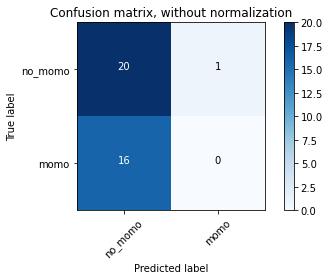

In [11]:
createConfusionMatrix(eval_Xs, eval_Ys, classes=getOutputClasses())

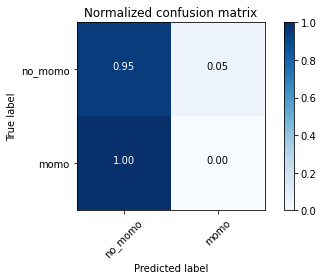

In [12]:
createConfusionMatrix(eval_Xs, eval_Ys, classes=getOutputClasses(), normalize=True)